In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-05,116.860001,115.809998,115.919998,116.610001,22193600.0,111.727715
2017-01-06,118.160004,116.470001,116.779999,117.910004,31751900.0,112.973305
2017-01-09,119.430000,117.940002,117.949997,118.989998,33561900.0,114.008080
2017-01-10,119.379997,118.300003,118.769997,119.110001,24462100.0,114.123047
2017-01-11,119.930000,118.599998,118.739998,119.750000,27588600.0,114.736275


In [2]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

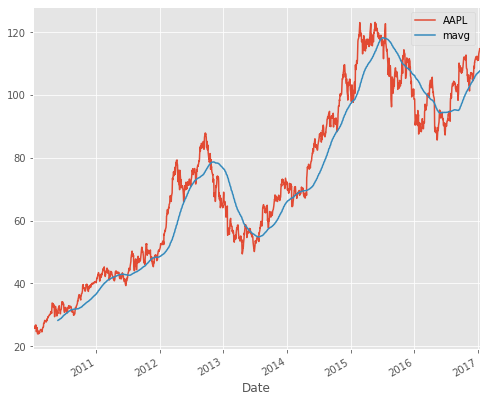

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

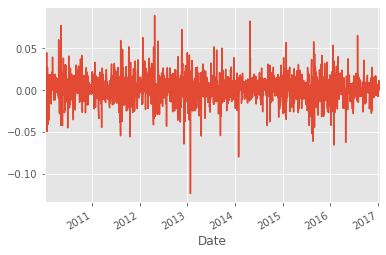

In [5]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [6]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [7]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()

Text(0, 0.5, 'Returns GE')

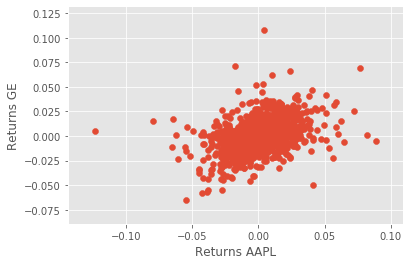

In [9]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

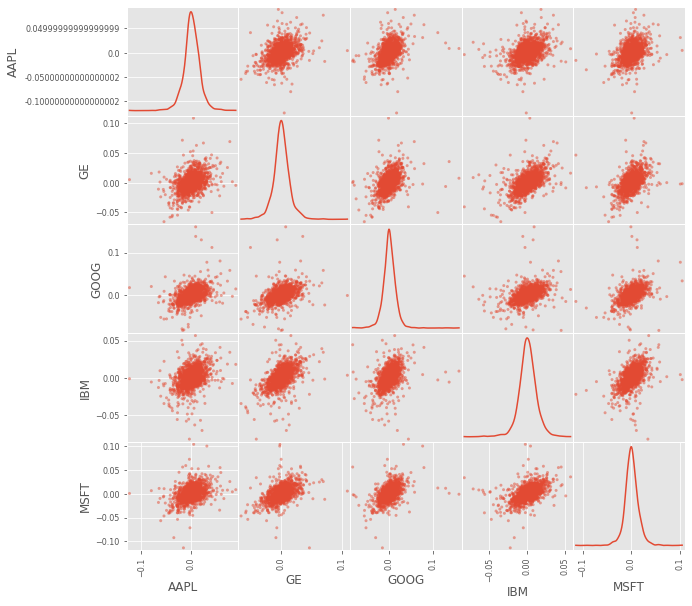

In [11]:
from pandas.plotting import scatter_matrix
scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

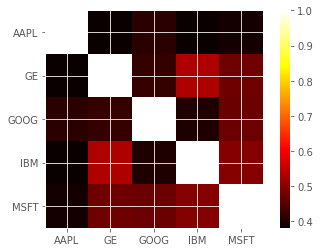

In [13]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

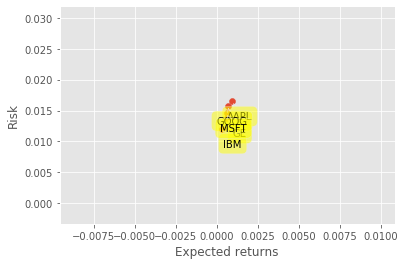

In [14]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [18]:
dfreg = df.loc[:,["Adj Close","Volume"]]
dfreg["HL_PCT"] = (df["High"] - df["Low"]) / df["Close"] * 100.0
dfreg["PCT_change"] = (df["Close"] - df["Open"]) / df["Open"] * 100.0
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2017-01-05,111.727715,22193600.0,0.900440,0.595240
2017-01-06,112.973305,31751900.0,1.433299,0.967636
2017-01-09,114.008080,33561900.0,1.252204,0.881730
2017-01-10,114.123047,24462100.0,0.906720,0.286271
2017-01-11,114.736275,27588600.0,1.110649,0.850600


In [26]:
import math
import numpy as np
import sklearn.preprocessing as preprocessing

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) 
#for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [44]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

# results
print('The linear regression confidence is ', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The knn regression confidence is ', confidenceknn)

list_of_clf = [clfreg,clfpoly2,clfpoly3,clfknn]
list_of_performance = [confidencereg,confidencepoly2,confidencepoly3,confidenceknn]

print("best performing is : ")
print(np.argmax(list_of_performance))
clf = list_of_clf[np.argmax(list_of_performance)]

The linear regression confidence is  0.9719574123804554
The quadratic regression 2 confidence is  0.9614831991002788
The quadratic regression 3 confidence is  0.9631563086926309
The knn regression confidence is  0.9441955548813696
best performing is : 
0


In [46]:
forecast_set = clf.predict(X_lately)
dfreg['Forecast'] = np.nan
print(forecast_set)

[110.34513901 110.25152381 111.56602988 111.59639354 111.51970182
 110.94460219 111.36918648 112.17820009 112.10931397 111.47994452
 111.01162686 111.11640532 110.73251166 111.35416974 112.61935692
 113.44500246 113.60989619 114.18645464]


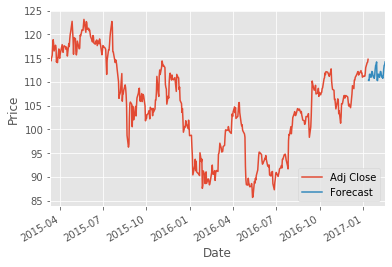

In [49]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()